In [28]:
"""
Implicit differentiation of lasso.
==================================
"""

from absl import app
from absl import flags

import jax
import jax.numpy as jnp

from jaxopt import BlockCoordinateDescent
from jaxopt import objective
from jaxopt import OptaxSolver
from jaxopt import prox
from jaxopt import ProximalGradient
import optax

from sklearn import datasets
from sklearn import model_selection
from sklearn import preprocessing

import numpy as np
import matplotlib.pyplot as plt

In [29]:
def outer_objective(theta, init_inner, data):
    """Validation loss."""
    X_tr, X_val, y_tr, y_val = data
    # We use the bijective mapping lam = jnp.exp(theta) to ensure positivity.
    lam = jnp.exp(theta)
    
    solver = ProximalGradient(
        fun=objective.least_squares,
        prox=prox.prox_lasso,
        implicit_diff=True,
        maxiter=500)

    # The format is run(init_params, hyperparams_prox, *args, **kwargs)
    # where *args and **kwargs are passed to `fun`.
    w_fit = solver.run(init_inner, lam, (X_tr, y_tr)).params

    y_pred = jnp.dot(X_val, w_fit)
    loss_value = jnp.mean((y_pred - y_val) ** 2)

    # We return w_fit as auxiliary data.
    # Auxiliary data is stored in the optimizer state (see below).
    return loss_value, w_fit

## Run Implicit differentiation on Lasso Regression

In [22]:
# Prepare data.
X, y = datasets.load_diabetes(return_X_y=True)
X = preprocessing.normalize(X)

data = model_selection.train_test_split(X, y, test_size=0.33, random_state=0)

In [27]:
print(X.shape)

(442, 10)


In [18]:
# Initialize solver.
solver = OptaxSolver(opt=optax.adam(1e-2), fun=outer_objective, has_aux=True)
theta = 1.0
init_w = jnp.zeros(X.shape[1])
state = solver.init_state(theta, init_inner=init_w, data=data)

# Run outer loop.
for _ in range(500):
    theta, state = solver.update(params=theta, state=state, init_inner=init_w,
                                 data=data)
    # The auxiliary data returned by the outer loss is stored in the state.
    #init_w = state.aux
    print(f"[Step {state.iter_num}] Validation loss: {state.value:.3f}, theta: {theta:.3f}.")

[Step 1] Validation loss: 27125.734, theta: 0.990.
[Step 2] Validation loss: 27122.301, theta: 0.980.
[Step 3] Validation loss: 27120.334, theta: 0.970.
[Step 4] Validation loss: 27119.172, theta: 0.960.
[Step 5] Validation loss: 27117.713, theta: 0.950.
[Step 6] Validation loss: 27115.965, theta: 0.940.
[Step 7] Validation loss: 27115.568, theta: 0.930.
[Step 8] Validation loss: 27115.824, theta: 0.921.
[Step 9] Validation loss: 27106.740, theta: 0.911.
[Step 10] Validation loss: 27111.428, theta: 0.901.
[Step 11] Validation loss: 27110.104, theta: 0.891.
[Step 12] Validation loss: 27112.914, theta: 0.882.
[Step 13] Validation loss: 27110.006, theta: 0.872.
[Step 14] Validation loss: 27106.973, theta: 0.863.
[Step 15] Validation loss: 27106.248, theta: 0.853.
[Step 16] Validation loss: 27105.043, theta: 0.844.
[Step 17] Validation loss: 27104.326, theta: 0.835.
[Step 18] Validation loss: 27108.686, theta: 0.826.
[Step 19] Validation loss: 27102.352, theta: 0.817.
[Step 20] Validation 

[Step 246] Validation loss: 27095.475, theta: 0.737.
[Step 247] Validation loss: 27095.742, theta: 0.738.
[Step 248] Validation loss: 27095.645, theta: 0.738.
[Step 249] Validation loss: 27095.492, theta: 0.738.
[Step 250] Validation loss: 27095.904, theta: 0.736.
[Step 251] Validation loss: 27146.006, theta: 0.736.
[Step 252] Validation loss: 27093.658, theta: 0.736.
[Step 253] Validation loss: 27095.467, theta: 0.734.
[Step 254] Validation loss: 27098.479, theta: 0.732.
[Step 255] Validation loss: 27095.369, theta: 0.730.
[Step 256] Validation loss: 27095.352, theta: 0.727.
[Step 257] Validation loss: 27095.000, theta: 0.723.
[Step 258] Validation loss: 27095.350, theta: 0.721.
[Step 259] Validation loss: 27097.363, theta: 0.721.
[Step 260] Validation loss: 27095.402, theta: 0.721.
[Step 261] Validation loss: 27095.492, theta: 0.723.
[Step 262] Validation loss: 27095.531, theta: 0.726.
[Step 263] Validation loss: 27095.014, theta: 0.728.
[Step 264] Validation loss: 27097.146, theta: 

[Step 471] Validation loss: 27095.945, theta: 0.739.
[Step 472] Validation loss: 27095.699, theta: 0.738.
[Step 473] Validation loss: 27095.699, theta: 0.736.
[Step 474] Validation loss: 27095.568, theta: 0.733.
[Step 475] Validation loss: 27095.428, theta: 0.730.
[Step 476] Validation loss: 27100.393, theta: 0.729.
[Step 477] Validation loss: 27094.463, theta: 0.727.
[Step 478] Validation loss: 27097.406, theta: 0.726.
[Step 479] Validation loss: 27130.324, theta: 0.726.
[Step 480] Validation loss: 27095.523, theta: 0.728.
[Step 481] Validation loss: 27096.365, theta: 0.731.
[Step 482] Validation loss: 27095.283, theta: 0.732.
[Step 483] Validation loss: 27095.121, theta: 0.733.
[Step 484] Validation loss: 27085.658, theta: 0.733.
[Step 485] Validation loss: 27095.240, theta: 0.732.
[Step 486] Validation loss: 27095.846, theta: 0.731.
[Step 487] Validation loss: 27095.213, theta: 0.728.
[Step 488] Validation loss: 27091.377, theta: 0.728.
[Step 489] Validation loss: 27098.645, theta: 

## Plot Lasso Validation loss

In [19]:
results = []
for theta in jnp.arange(-5, 5, 0.1):
    loss, _ = outer_objective(theta, jnp.zeros(X.shape[1]), data)
    results.append([theta, loss])
    print(theta)

-5.0
-4.9
-4.8
-4.7000003
-4.6000004
-4.5000005
-4.4000006
-4.3000007
-4.200001
-4.100001
-4.000001
-3.900001
-3.8000011
-3.7000012
-3.6000013
-3.5000014
-3.4000015
-3.3000016
-3.2000017
-3.1000018
-3.000002
-2.900002
-2.800002
-2.7000022
-2.6000023
-2.5000024
-2.4000025
-2.3000026
-2.2000027
-2.1000028
-2.0000029
-1.900003
-1.800003
-1.7000031
-1.6000032
-1.5000033
-1.4000034
-1.3000035
-1.2000036
-1.1000037
-1.0000038
-0.9000039
-0.800004
-0.7000041
-0.6000042
-0.5000043
-0.4000044
-0.30000448
-0.20000458
-0.10000467
-4.7683716e-06
0.099995136
0.19999504
0.29999495
0.39999485
0.49999475
0.59999466
0.69999456
0.79999447
0.8999944
0.9999943
1.0999942
1.1999941
1.299994
1.3999939
1.4999938
1.5999937
1.6999936
1.7999935
1.8999934
1.9999933
2.0999932
2.1999931
2.299993
2.399993
2.4999928
2.5999928
2.6999927
2.7999926
2.8999925
2.9999924
3.0999923
3.1999922
3.299992
3.399992
3.499992
3.5999918
3.6999917
3.7999916
3.8999915
3.9999914
4.0999913
4.199991
4.299991
4.399991
4.499991
4.599991
4.

Text(0.5, 1.0, 'implicit differentiation of LASSO')

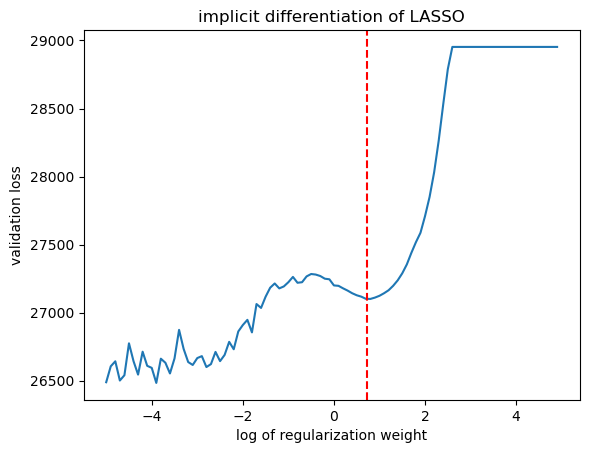

In [20]:
thetas = np.array(results)[:, 0]
loss = np.array(results)[:, 1]
plt.plot(thetas, loss)
plt.axvline(x=0.729, color='red', linestyle='--')
plt.xlabel('log of regularization weight')            # Label for x-axis
plt.ylabel('validation loss')            # Label for y-axis
plt.title('implicit differentiation of LASSO')  # Title of the plot

## Plot Hyperparameter Gradient

0.0
0.01
0.02
0.03
0.04
0.049999997
0.06
0.07
0.08
0.089999996
0.099999994
0.11
0.12
0.13
0.14
0.14999999
0.16
0.17
0.17999999
0.19
0.19999999
0.21
0.22
0.22999999
0.24
0.25
0.26
0.26999998
0.28
0.29
0.29999998
0.31
0.32
0.32999998
0.34
0.35
0.35999998
0.37
0.38
0.39
0.39999998
0.41
0.42
0.42999998
0.44
0.45
0.45999998
0.47
0.48
0.48999998
0.5
0.51
0.52
0.53
0.53999996
0.55
0.56
0.57
0.58
0.59
0.59999996
0.61
0.62
0.63
0.64
0.65
0.65999997
0.66999996
0.68
0.69
0.7
0.71
0.71999997
0.72999996
0.74
0.75
0.76
0.77
0.78
0.78999996
0.79999995
0.81
0.82
0.83
0.84
0.84999996
0.85999995
0.87
0.88
0.89
0.9
0.90999997
0.91999996
0.93
0.94
0.95
0.96
0.96999997
0.97999996
0.98999995
1.0
1.01
1.02
1.03
1.04
1.05
1.06
1.0699999
1.0799999
1.09
1.1
1.11
1.12
1.13
1.14
1.15
1.16
1.17
1.18
1.1899999
1.1999999
1.2099999
1.22
1.23
1.24
1.25
1.26
1.27
1.28
1.29
1.3
1.31
1.3199999
1.3299999
1.3399999
1.35
1.36
1.37
1.38
1.39
1.4
1.41
1.42
1.43
1.4399999
1.4499999
1.4599999
1.4699999
1.48
1.49
1.5
1.51
1.52
1

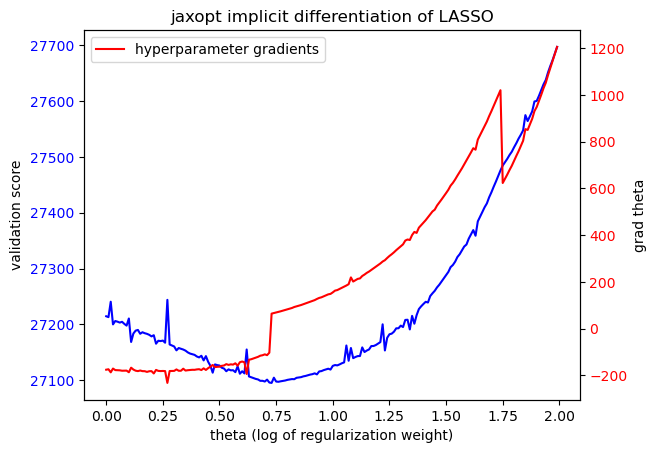

In [21]:
grad_theta = jax.grad(outer_objective, has_aux=True)

results = []
for theta in jnp.arange(0, 2, 0.01):
    loss, _ = outer_objective(theta, jnp.zeros(X.shape[1]), data)
    reg_grad, _ = grad_theta(theta, jnp.zeros(X.shape[1]), data)
    results.append([theta, loss, float(reg_grad)])
    print(theta)

thetas = np.array(results)[:, 0]
loss = np.array(results)[:, 1]
grads = np.array(results)[:, 2]

fig, ax1 = plt.subplots()
ax1.plot(thetas, loss, color='blue', label='validation scores')
ax1.set_xlabel('theta (log of regularization weight)')
ax1.set_ylabel('validation score')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(thetas, grads, color='red', label='hyperparameter gradients')
ax2.set_xlabel('theta (log of regularization weight)')
ax2.set_ylabel('grad theta')
ax2.tick_params(axis='y', labelcolor='red')

#plt.plot(thetas, loss, label='validation loss for theta')
           # Label for y-axis
plt.title('jaxopt implicit differentiation of LASSO')  # Title of the plot
plt.legend()